## Treliça

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
%matplotlib inline

In [219]:
A_0 = 100  # mm^2
E = 2e5   # N/mm^2
L = 1.5e3*np.array([np.sqrt(2),1,1])     # mm
F = np.array([0,500,-500]).reshape(3,1)  # N

In [220]:
def k_bar(Ai,Li):
    return(Ai * E / Li)

def k_matrix(A):
    A1,A2,A3 = A[0],A[1],A[2]
    L1,L2,L3 = L[0],L[1],L[2]
    k_1 = k_bar(A1,L1)
    k_2 = k_bar(A2,L2)
    k_3 = k_bar(A3,L3)
    return(np.array([k_1 + k_2,-k_1,-k_1,
                    -k_1,k_1 + k_2,k_1,
                    -k_1,k_1,k_1]).reshape(3,3))

def u_desl(A):
    K = k_matrix(A)
    u = solve(K,F)
    return(u)

def dk_dA(A):
    L1,L2,L3 = L[0],L[1],L[2]
    dk1 = E / (2 * L1) * np.array([1,-1,-1,
                                 -1,1,1,
                                 -1,1,1]).reshape(3,3)
    dk2 = E / (L2) * np.array([0,0,0,
                               0,1,0,
                               0,0,0]).reshape(3,3)
    dk3 = E / (L3) * np.array([1,0,0,
                               0,0,0,
                               0,0,0]).reshape(3,3)
    return(dk1,dk2,dk3)
    

def du_dA(A):
    u = u_desl(A)
    K = k_matrix(A)
    dk1,dk2,dk3 = dk_dA(A)
    return(solve(K,np.matmul(-dk1,u)),
           solve(K,np.matmul(-dk2,u)),
           solve(K,np.matmul(-dk3,u)))

def f(A):
    u = u_desl(A)
    return(0.5*np.matmul(F.T,u)[0])

def g_V(A):
    return(np.dot(A,L) - 300 * np.sum(L))

def g_A(A):
    return(A_0 - np.array(A))

def g_A2(A):
    return(np.array(A) - 500)

def lagr(A):
    return(f(A) + r_v * max(0,g_V(A))**2
           + np.dot(r_A,np.maximum(g_A(A),0)**2)
           + np.dot(r_A,np.maximum(g_A2(A),0)**2))

def grad_dir(A):    
    L1,L2,L3 = L[0],L[1],L[2]
    Vg = r_v * max(0,g_V(A))
    Ag = r_A*np.maximum(g_A(A),0)
    Ag2 = r_A*np.maximum(g_A2(A),0)
    uA = du_dA(A)
    return(np.array([L1 * Vg - Ag[0] + Ag2[0]
           + 0.5*np.matmul(F.T,uA[0])[0][0],
           L2 * Vg - Ag[1] + Ag2[1]
           + 0.5*np.matmul(F.T,uA[1])[0][0],
           L3 * Vg - Ag[2] + Ag2[2]
           + 0.5*np.matmul(F.T,uA[2])[0][0]]).reshape(3,1))

def grad_adj(A):
    L1,L2,L3 = L[0],L[1],L[2]
    Vg = r_v * max(0,g_V(A))
    Ag = r_A*np.maximum(g_A(A),0)    
    Ag2 = r_A*np.maximum(g_A2(A),0)
    dk1,dk2,dk3 = dk_dA(A)
    u = u_desl(A)
    ga1 = -np.matmul(np.matmul(dk1,u).T,u)[0][0]
    ga2 = -np.matmul(np.matmul(dk2,u).T,u)[0][0]
    ga3 = -np.matmul(np.matmul(dk3,u).T,u)[0][0]
    return(np.array([L1 * Vg - Ag[0] + Ag2[0] + ga1,
                     L2 * Vg - Ag[1] + Ag2[1] + ga2,
                     L3 * Vg - Ag[2] + Ag2[2] + ga3]).reshape(3,1))

def hess_num(x0,df,alpha,d,H=np.eye(3)):
    try:
        solve(H,-df,check_finite=True).T
    except:
        H = np.eye(3)
    c = grad_adj(x0 + alpha * d)
    y = c - df
    s = alpha * d
    #print(df,d,'ys')
    if y.all() == 0:
        D = 0
    else:
        D = np.matmul(y,y.T) / np.dot(y.T,s)
    E = np.matmul(df,df.T) / np.dot(df.T[0],d)
    
    return(H + D + E)

def direction(x0,flag,alpha=1,d2f=0):
    df = grad_adj(x0)
    if flag == 0:
        d = -df.T
    elif flag == 1:
        df = grad_adj(x0)
        if type(d2f) == int:
            d2f = np.eye(3)
        try:
            d = solve(d2f,-df,sym_pos=True,check_finite=True).T
        except:
            ll = 1e1
            d2f = d2f + ll * np.eye(3)
            d = solve(d2f,-df).T
            while lagr(x0) < lagr(x0 + alpha*d[0]):
                ll = ll * 2
                if np.isnan(d2f).any():
                    d2f = ll * np.eye(3)
                else:
                    d2f = d2f + ll * np.eye(3)
                d = solve(d2f,-df).T
    return(d)

def step(x0,d,inc=1e-6):
    soma = 0
    ll1 = lagr(x0)
    m = (np.sqrt(5) + 1) / 2
    x1 = x0 + inc*d
    while lagr(x1) > ll1:
        inc = inc / 10
        x1 = x0 + inc * d
    for i in range(100):
        soma += m**i
        if lagr(x0+inc*(soma)*d) > ll1 and i > 0:
            break
        elif lagr(x0+inc*(soma)*d) > ll1 and i == 0:
            inc = inc / 2
    I = inc * m**(i-1)*(1+m)
    T = 1 / m
    Au = inc * (soma)
    Al = inc * (soma - m**i*(1+1/m))
    Ab = T * I + Al
    Aa = (1-T) * I + Al
    fa = lagr(x0+Aa*d)
    fb = lagr(x0+Ab*d)
    while I > 1e-3:
        if fa < fb:
            Au, Ab = Ab, Aa    
            Aa = Al + (1-T) * (Au-Al)
            fb, fa = fa, lagr(x0+Aa*d)
        elif fa > fb:
            Al, Aa = Aa, Ab            
            Ab = T * (Au-Al) + Al
            fa, fb = fb, lagr(x0+Ab*d)
        else:
            Al,Au = Aa, Ab            
            Ab = T * (Au-Al) + Al
            Aa = (1-T) * (Au-Al) + Al
            fa = lagr(x0+Aa*d)
            fb = lagr(x0+Ab*d)
        I = Au - Al
    AA = 0.5*(Au+Al)
    return(AA)

In [268]:
r_v = 1e-9
r_A = [1e3]*3
A0 = [300,400,200]
l,dl= lagr(A0),grad_adj(A0)
d2l = hess_num(A0,dl,1,-dl.T[0])
print(l,np.linalg.norm(dl),d2l)
d = direction(A0,1,1,d2l)[0]
inc = 5e1
a = step(A0,d,inc)
var = A0
Appp = [[0,0,0]]*10
# print(lagr(var+a*d))

for i in range(500):
    #print(lagr(var+a*d))
    if np.linalg.norm(dl) <= 1e-6:
        break
#     elif i > 90 and Appp[i-10:i] == Appp[i-20:i-10]:
#         break
    elif lagr(var + a * d) < l:
        print(i,var,lagr(var))
        while lagr(var + a * d) < l:
            dA = a * d
            var += dA
            l,dl = lagr(var),grad_adj(var)
            a = step(var,d,inc)
    else:        
        d = direction(var,1,a,d2l)[0]
        d2l = hess_num(var,dl,a,d,d2l)
        a = step(var,d,inc)
        l,dl = lagr(var),grad_adj(var)
    Appp.append(var)
    
print(var,'\n',lagr(var),'\n',np.linalg.norm(dl),'\n',i)

[ 16.13816738] 0.0505134498471 [[ 0.91932659 -0.26736081 -0.06453246]
 [-0.26736081  0.14130792 -0.21295076]
 [-0.06453246 -0.21295076  0.94840977]]
0 [300, 400, 200] [ 16.13816738]
2 [ 300.81188243  402.61779701  200.64700121] [ 16.09386214]
4 [ 300.81283901  402.62090081  200.64776418] [ 16.09386208]
6 [ 300.81775378  402.63717855  200.65169538] [ 16.09386104]
8 [ 300.82068927  402.64709502  200.65404991] [ 16.09386043]
10 [ 300.82860293  402.67497766  200.66043728] [ 16.0938558]
12 [ 300.83229485  402.6882552   200.66342619] [ 16.09385475]
14 [ 300.83600398  402.70186945  200.66643821] [ 16.09385369]
16 [ 300.83959965  402.71534149  200.66936725] [ 16.09385264]
18 [ 300.84313776  402.72887562  200.67225866] [ 16.09385157]
20 [ 300.84674525  402.74296705  200.67521649] [ 16.09385046]
22 [ 300.85024146  402.75691516  200.67809277] [ 16.09384939]
24 [ 300.85370337  402.77102393  200.68095074] [ 16.0938483]
26 [ 300.85711812  402.78524295  200.68377982] [ 16.09384721]
28 [ 300.86046264 

In [151]:
var,i

(array([ 220.38606381,  500.00000937,  176.6718347 ]), 99)

In [524]:
lagr(var),np.linalg.norm(dl),a*d,d2l

(array([  1.46235098e-11]),
 1.8627530067465674e-14,
 array([ -4.48918448e-14,  -5.50064515e-15,   3.20554532e-14]),
 array([[-28.59717344,  60.39614002, -16.00452362],
        [ 60.39614002, -55.84312876,  76.24685077],
        [-16.00452362,  76.24685077, -19.44662109]]))

In [72]:
e1 = hess_num(A0,grad_dir(A0),1,-grad_dir(A0).T[0])
t1 = direction(A0,1,1,e1)[0]
a3 = step(A0,t1,1)
var = A0 + a3*t1
var

array([ 227.19582238,  485.36852431,  217.59213108])

In [70]:
e2 = hess_num(var,grad_dir(var),a3,t1)
t2 = direction(var,1,a3,e2)[0]
var += step(var,t2,1e6)*t2
var

array([ 227.19582238,  485.36852431,  217.59213108])

In [87]:
Appp

[[0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),
 array([ 309.14848238,  486.43210428,  101.15166805]),


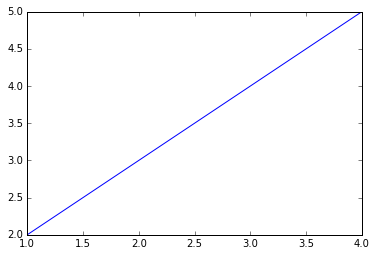

In [270]:
plt.plot([1,2,3,4],[2,3,4,5])